## **Support Vector Machine from Scratch**

In [2]:
import numpy as np
import matplotlib.pyplot as plt


This class implements a Support Vector Machine classifier using the Sequential Minimal Optimization (SMO) algorithm. The implementation includes both linear and non-linear kernels, making it capable of handling complex decision boundaries.

## Class Parameters

- **kernel**: Type of kernel function ('rbf' or 'polynomial')
  - 'rbf': Radial Basis Function kernel, good for non-linear data
  - 'polynomial': Polynomial kernel (degree 3)
- **C**: Regularization parameter (default=1.0)
  - Controls the trade-off between margin maximization and classification error
  - Larger values = harder margin, less tolerance for misclassification
  - Smaller values = softer margin, more tolerance for misclassification
- **gamma**: Kernel coefficient for RBF kernel (default=0.1)
  - Controls the influence of single training examples
  - Larger values = closer decision boundary, can lead to overfitting
  - Smaller values = smoother decision boundary
- **max_iter**: Maximum number of iterations (default=1000)
- **tol**: Tolerance for stopping criterion (default=1e-3)

## Main Methods

### 1. Kernel Functions
- `kernel_function(x1, x2)`: Computes kernel value between two data points
- `kernel_matrix(X1, X2)`: Computes full kernel matrix between two sets of points

### 2. Training
- `fit(X, y)`: Trains the SVM model using SMO algorithm
  - Implements full SMO with heuristics for choosing pairs of alphas
  - Stores support vectors and their corresponding alphas
  - Prints training progress every 100 iterations

### 3. Prediction
- `predict(X)`: Makes predictions on new data points
  - Returns -1 or 1 for binary classification
  - Uses stored support vectors for prediction

## Internal Methods

- `_decision_function_training`: Computes decision function during training
- `_examine_example`: Implements main SMO loop for selecting examples
- `_take_step`: Implements the core SMO optimization step

## Support Vector Selection

The model automatically selects support vectors during training (points with alpha > 1e-5). These are the crucial points that define the decision boundary. The number of support vectors can indicate model complexity:
- Many support vectors → Complex decision boundary, potential overfitting
- Fewer support vectors → Simpler decision boundary, better generalization


In [5]:
class SVM:
    def __init__(self, kernel='rbf', C=1.0, gamma=0.1, max_iter=1000, tol=1e-3):
        self.kernel = kernel
        self.C = C
        self.gamma = gamma
        self.max_iter = max_iter
        self.tol = tol
        self.alphas = None
        self.support_vectors = None
        self.support_vector_labels = None
        self.support_vector_alphas = None
        self.b = 0
        self.X_train = None
        self.y_train = None
        self.K = None
        
    def kernel_function(self, x1, x2):
        if self.kernel == 'rbf':
            return np.exp(-self.gamma * np.sum((x1 - x2) ** 2))
        elif self.kernel == 'polynomial':
            return (np.dot(x1, x2) + 1) ** 3
        
    def kernel_matrix(self, X1, X2):
        K = np.zeros((len(X1), len(X2)))
        for i, x1 in enumerate(X1):
            for j, x2 in enumerate(X2):
                K[i, j] = self.kernel_function(x1, x2)
        return K
    
    def _decision_function_training(self, idx):
        """Decision function during training"""
        if self.alphas is None:
            return 0
        return np.sum(self.alphas * self.y_train * self.K[idx]) + self.b
    
    def fit(self, X, y):
        n_samples = len(X)
        self.X_train = X
        self.y_train = y
        
        self.alphas = np.zeros(n_samples)
        self.b = 0
        
        self.K = self.kernel_matrix(X, X)
        
        errors = np.zeros(n_samples)
        for i in range(n_samples):
            errors[i] = self._decision_function_training(i) - y[i]
        
        num_changed = 0
        examine_all = True
        iteration = 0
        
        while (num_changed > 0 or examine_all) and iteration < self.max_iter:
            num_changed = 0
            iteration += 1
            
            if examine_all:
                for i in range(n_samples):
                    num_changed += self._examine_example(i, errors)
            else:
                for i in np.where((self.alphas != 0) & (self.alphas != self.C))[0]:
                    num_changed += self._examine_example(i, errors)
            
            if examine_all:
                examine_all = False
            elif num_changed == 0:
                examine_all = True
                
            if iteration % 100 == 0:
                print(f"Iteration {iteration}, number of changed alphas: {num_changed}")
        
        support_vector_indices = self.alphas > 1e-5
        self.support_vectors = X[support_vector_indices]
        self.support_vector_labels = y[support_vector_indices]
        self.support_vector_alphas = self.alphas[support_vector_indices]
        
        print(f"Finished training after {iteration} iterations")
        print(f"Number of support vectors: {len(self.support_vectors)}")
    
    def _examine_example(self, i, errors):
        y_i = self.y_train[i]
        alpha_i = self.alphas[i]
        E_i = errors[i]
        r = E_i * y_i
        
        if ((r < -self.tol and alpha_i < self.C) or (r > self.tol and alpha_i > 0)):
            if len(self.alphas[(self.alphas != 0) & (self.alphas != self.C)]) > 1:
                if E_i > 0:
                    j = np.argmin(errors)
                else:
                    j = np.argmax(errors)
                if self._take_step(i, j, errors):
                    return 1
            
            for j in np.random.permutation(np.where((self.alphas != 0) & (self.alphas != self.C))[0]):
                if self._take_step(i, j, errors):
                    return 1
            
            for j in np.random.permutation(len(self.alphas)):
                if self._take_step(i, j, errors):
                    return 1
        
        return 0
    
    def _take_step(self, i, j, errors):
        if i == j:
            return False
        
        alpha_i = self.alphas[i]
        alpha_j = self.alphas[j]
        y_i = self.y_train[i]
        y_j = self.y_train[j]
        E_i = errors[i]
        E_j = errors[j]
        
        s = y_i * y_j
        
        if y_i != y_j:
            L = max(0, alpha_j - alpha_i)
            H = min(self.C, self.C + alpha_j - alpha_i)
        else:
            L = max(0, alpha_i + alpha_j - self.C)
            H = min(self.C, alpha_i + alpha_j)
        
        if L == H:
            return False
        
        eta = 2 * self.K[i, j] - self.K[i, i] - self.K[j, j]
        if eta >= 0:
            return False
        
        alpha_j_new = alpha_j - y_j * (E_i - E_j) / eta
        alpha_j_new = np.clip(alpha_j_new, L, H)
        
        if abs(alpha_j_new - alpha_j) < 1e-5:
            return False
        
        alpha_i_new = alpha_i + s * (alpha_j - alpha_j_new)
        
        b_i = self.b - E_i - y_i * (alpha_i_new - alpha_i) * self.K[i, i] - y_j * (alpha_j_new - alpha_j) * self.K[i, j]
        b_j = self.b - E_j - y_i * (alpha_i_new - alpha_i) * self.K[i, j] - y_j * (alpha_j_new - alpha_j) * self.K[j, j]
        
        if 0 < alpha_i_new < self.C:
            self.b = b_i
        elif 0 < alpha_j_new < self.C:
            self.b = b_j
        else:
            self.b = (b_i + b_j) / 2
        
        self.alphas[i] = alpha_i_new
        self.alphas[j] = alpha_j_new
        
        for k in range(len(errors)):
            errors[k] = self._decision_function_training(k) - self.y_train[k]
        
        return True
    
    def predict(self, X):
        if self.support_vectors is None:
            return np.zeros(len(X))
        
        K = self.kernel_matrix(X, self.support_vectors)
        
        return np.sign(np.dot(K, self.support_vector_alphas * self.support_vector_labels) + self.b)

Generates synthetic binary classification data with three overlapping clusters per class, including non-linear transformations and controllable noise through the `complexity` parameter.

In [8]:
def generate_data(n_samples=300, complexity=0.8):
    n_samples_per_class = n_samples // 2
    n_clusters = 3
    samples_per_cluster = n_samples_per_class // n_clusters
    
    centers1 = [[2, 2], [0, 3], [3, 0]]
    centers2 = [[-2, -2], [0, -3], [-3, 0]]
    
    X1 = np.vstack([
        np.random.randn(samples_per_cluster, 2) * (1 + complexity) + center
        for center in centers1
    ])
    X2 = np.vstack([
        np.random.randn(samples_per_cluster, 2) * (1 + complexity) + center
        for center in centers2
    ])
    
    theta = np.random.rand(len(X1)) * 2 * np.pi
    X1 = X1 + complexity * np.column_stack([np.cos(theta), np.sin(theta)])
    X2 = X2 + complexity * np.column_stack([np.cos(theta), np.sin(theta)])
    
    X1 += np.random.randn(*X1.shape) * complexity * 0.5
    X2 += np.random.randn(*X2.shape) * complexity * 0.5
    
    X = np.vstack([X1, X2])
    y = np.array([1] * len(X1) + [0] * len(X2))
    
    shuffle_idx = np.random.permutation(len(X))
    return X[shuffle_idx], y[shuffle_idx]

### Model Evaluation and Visualization

##### Metrics Calculation
Computes comprehensive binary classification metrics including accuracy, precision, recall, F1-score, and confusion matrix components.

##### Decision Boundary Visualization
Creates a 2D plot showing the SVM decision boundary, training/test data points, and support vectors with distinct markers and colors.

##### Metrics Display
Formats and prints the classification metrics in a clear, organized way with proper headers and sections.

In [11]:
def calculate_metrics(y_true, y_pred):
    """
    Calculate comprehensive classification metrics
    """
    tp = np.sum((y_true == 1) & (y_pred == 1))
    tn = np.sum((y_true == 0) & (y_pred == 0))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))
    
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    balanced_accuracy = (recall + specificity) / 2
    
    metrics = {
        'Accuracy': accuracy,
        'Balanced Accuracy': balanced_accuracy,
        'Precision': precision,
        'Recall (Sensitivity)': recall,
        'Specificity': specificity,
        'F1 Score': f1,
        'True Positives': tp,
        'True Negatives': tn,
        'False Positives': fp,
        'False Negatives': fn
    }
    
    return metrics

def plot_decision_boundary(X_train, X_test, y_train, y_test, svm_classifier):
    """
    Plot decision boundary with distinct train and test data points
    """
    plt.figure(figsize=(12, 8))
    
    x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
    y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                        np.linspace(y_min, y_max, 100))
    
    mesh_points = np.c_[xx.ravel(), yy.ravel()]
    Z = svm_classifier.predict(mesh_points)
    Z = Z.reshape(xx.shape)
    
    Z = (Z + 1) // 2
    
    plt.contourf(xx, yy, Z, alpha=0.2, cmap=plt.cm.RdBu_r)
    plt.contour(xx, yy, Z, colors='k', levels=[0.5], alpha=0.5, linestyles=['-'])
    
    plt.scatter(X_train[y_train == 1][:, 0], X_train[y_train == 1][:, 1], 
               c='red', marker='o', label='Class 1 (Train)', alpha=0.6)
    plt.scatter(X_train[y_train == 0][:, 0], X_train[y_train == 0][:, 1], 
               c='blue', marker='o', label='Class 0 (Train)', alpha=0.6)
    
    plt.scatter(X_test[y_test == 1][:, 0], X_test[y_test == 1][:, 1], 
               c='red', marker='^', label='Class 1 (Test)', alpha=0.6)
    plt.scatter(X_test[y_test == 0][:, 0], X_test[y_test == 0][:, 1], 
               c='blue', marker='^', label='Class 0 (Test)', alpha=0.6)
    
    if hasattr(svm_classifier, 'support_vectors'):
        plt.scatter(svm_classifier.support_vectors[:, 0], 
                   svm_classifier.support_vectors[:, 1],
                   s=100, linewidth=1, facecolors='none', 
                   edgecolors='k', label='Support Vectors')
    
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title('SVM Decision Boundary')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.grid(True, alpha=0.3)
    plt.show()

def print_metrics(metrics, dataset_name=""):
    """
    Print metrics in a formatted way
    """
    print(f"\n{dataset_name} Metrics:")
    print("-" * 50)
    print(f"Accuracy: {metrics['Accuracy']:.3f}")
    print(f"Balanced Accuracy: {metrics['Balanced Accuracy']:.3f}")
    print(f"Precision: {metrics['Precision']:.3f}")
    print(f"Recall (Sensitivity): {metrics['Recall (Sensitivity)']:.3f}")
    print(f"Specificity: {metrics['Specificity']:.3f}")
    print(f"F1 Score: {metrics['F1 Score']:.3f}")
    print("\nConfusion Matrix:")
    print(f"True Positives: {metrics['True Positives']}")
    print(f"True Negatives: {metrics['True Negatives']}")
    print(f"False Positives: {metrics['False Positives']}")
    print(f"False Negatives: {metrics['False Negatives']}")

Training SVM...
Iteration 100, number of changed alphas: 22
Iteration 200, number of changed alphas: 13
Iteration 300, number of changed alphas: 25
Iteration 400, number of changed alphas: 7
Iteration 500, number of changed alphas: 13
Iteration 600, number of changed alphas: 27
Iteration 700, number of changed alphas: 14
Iteration 800, number of changed alphas: 29
Iteration 900, number of changed alphas: 7
Iteration 1000, number of changed alphas: 10
Finished training after 1000 iterations
Number of support vectors: 77

Model Summary:
Number of support vectors: 77
Kernel: RBF (gamma=1.0)
C parameter: 10.0

Training Metrics:
--------------------------------------------------
Accuracy: 0.904
Balanced Accuracy: 0.903
Precision: 0.911
Recall (Sensitivity): 0.887
Specificity: 0.920
F1 Score: 0.899

Confusion Matrix:
True Positives: 102
True Negatives: 115
False Positives: 10
False Negatives: 13

Testing Metrics:
--------------------------------------------------
Accuracy: 0.850
Balanced Acc

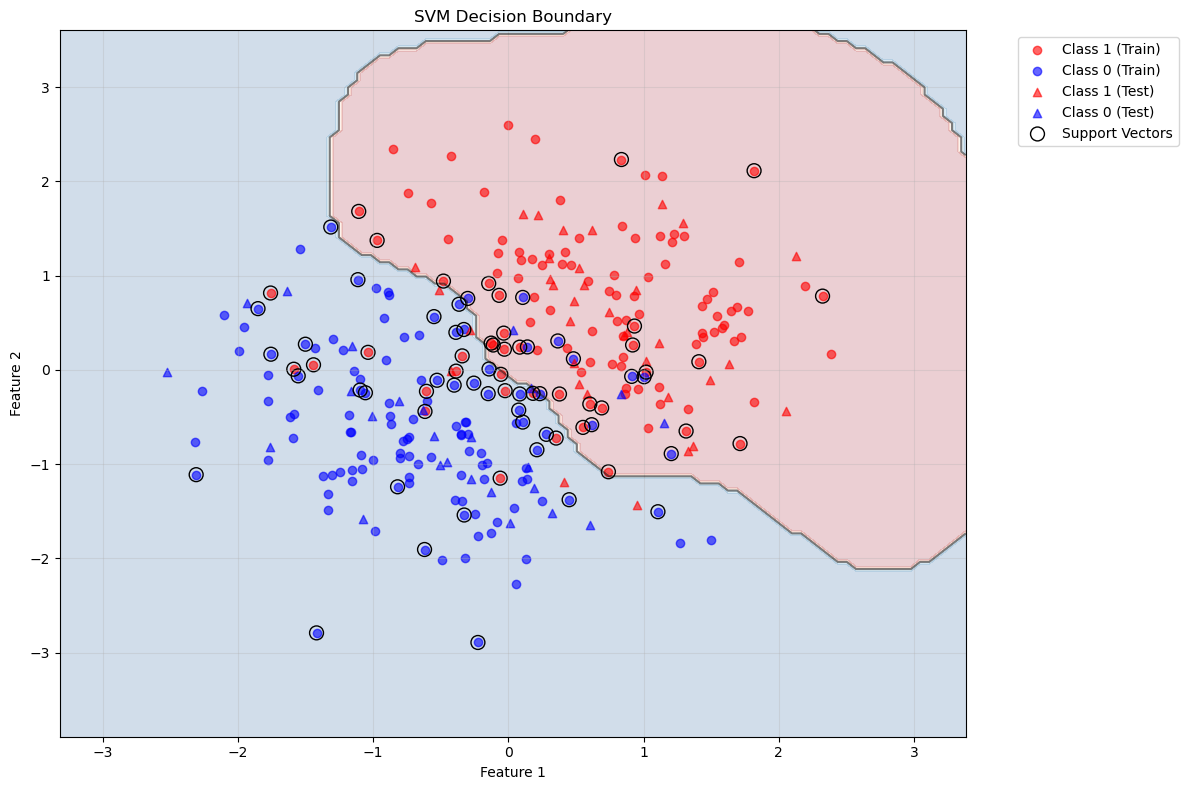

In [13]:
def main():
    
    X, y = generate_data(n_samples=300, complexity=0.8)
    
    X = (X - X.mean(axis=0)) / X.std(axis=0)
    
    train_idx = np.random.choice(len(X), int(0.8 * len(X)), replace=False)
    test_idx = np.array(list(set(range(len(X))) - set(train_idx)))
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    
    y_train_svm = np.where(y_train == 0, -1, 1)
    y_test_svm = np.where(y_test == 0, -1, 1)
    
    svm = SVM(
        kernel='rbf',
        C=10.0,
        gamma=1.0,
        max_iter=1000,
        tol=1e-3
    )
    
    print("Training SVM...")
    svm.fit(X_train, y_train_svm)
    
    y_pred_train = svm.predict(X_train)
    y_pred_test = svm.predict(X_test)
    
    y_pred_train = (y_pred_train + 1) // 2
    y_pred_test = (y_pred_test + 1) // 2
    
    train_metrics = calculate_metrics(y_train, y_pred_train)
    test_metrics = calculate_metrics(y_test, y_pred_test)
    
    print("\nModel Summary:")
    print(f"Number of support vectors: {len(svm.support_vectors)}")
    print(f"Kernel: RBF (gamma={svm.gamma})")
    print(f"C parameter: {svm.C}")
    
    print_metrics(train_metrics, "Training")
    print_metrics(test_metrics, "Testing")
    
    plot_decision_boundary(X_train, X_test, y_train, y_test, svm)

if __name__ == "__main__":
    main()